In [59]:
# Importing necessary Libraries
import os
import time
import random
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import FileLink
from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [60]:
# Verifying if a GPU accelerator is correctly working
!nvidia-smi

Sun May  2 15:44:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |  15509MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [66]:
# Verifying that Personal test data (ships-test) and Provided (ships2021) are accessible
!ls /kaggle/input

ships-test  ships2021


### ***Prepping for the Training of our model***

In [67]:
# Verify if input contains the provided dataset tarball
!ls /kaggle/input/ships2021

ships2021.tgz


In [68]:
# Extract provided dataset and others files from the tarball ships2021.tgz
!tar xzf /kaggle/input/ships2021/ships2021.tgz

In [69]:
# Verifying that all 13 classes with their training data are correctly extracted
!ls /kaggle/working/train

coastguard     corvette  cv	    ferry      sailing	  submarine  vsmallfish
containership  cruiser	 destroyer  methanier  smallfish  tug


In [70]:
# Extract personal test dataset tarball ships_test.tgz
!tar xzf /kaggle/input/ships-test/ships_test.tgz

In [111]:
# Verifying that all 13 classes with their test data are correctly extracted
!ls /kaggle/working/test

coastguard     corvette  cv	    ferry      sailing	  submarine  vsmallfish
containership  cruiser	 destroyer  methanier  smallfish  tug


### ***USEFUL VARIABLES***

In [72]:
LR = 1e-4                           # Learning Rate of 0.0001
SEED = 42                           # In order to get reproducible results we canr use a global SEED while training our model
EPOCHS = 20                         # Number of Epochs or Iteration we want for the training of our model
CLASSES = 13                        # Total Number of classes our Image Classifier should look for
BATCH_SIZE = 16                     # Batch size will be used to set the number of training examples utilized in one iteration of our model's training 
x, y = 128, 192                     # Default Image Height (y) and Width (x)
VALIDATION_SPLIT = 0.1              # Spliting amount set to split provided image data into train and validation sets
TRAIN_DIR = "/kaggle/working/train" # Default directory where train data is located

### ***Training and Validation data generator***

In [73]:
# We will be using an ImageDataGenerator to create our Training and Validation data

imgdatagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        horizontal_flip=True,              # Apply random horizontal flip on images
        
        rotation_range=20,                 # Apply random rotation raning from -20 to +20 degrees
        shear_range=0.2,                   # Apply random tranformation on x and y axis
        zoom_range=0.2,                    # Zoom into image
        brightness_range=[0.2,1.1],        # Change image brightness from 0.2 to 1.1
        width_shift_range=0.2,             # Shift image right and left
        height_shift_range=0.2,            # Shift image up and down
        fill_mode='nearest',               # While applying shifts and rotations on image we fill the values of pixels using thoses present nearby
        validation_split=VALIDATION_SPLIT, # Spliting training and validations subsets using the given amount
)

train_generator = imgdatagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(x, y),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=SEED,
        subset="training"
)

validation_generator = imgdatagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(x, y),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        seed=SEED,
        subset="validation"
)

Found 44572 images belonging to 13 classes.
Found 4945 images belonging to 13 classes.


### ***Calulating class_weight to take in account the proportion of data per class***

In [74]:
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weight = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
class_weight

{0: 2.062962962962963,
 1: 1.0092241805303903,
 2: 2.3077212806026366,
 3: 1.0098895665073349,
 4: 3.4733560090702946,
 5: 1.0,
 6: 1.9873499837820305,
 7: 2.027465254798147,
 8: 4.114842175957018,
 9: 2.1423076923076922,
 10: 2.3748062015503875,
 11: 2.062962962962963,
 12: 2.102608098833219}

### ***Some useful callbacks to fine tune the model***

In [79]:
earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=10,
                          mode='auto',
                          verbose=1,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=1/3,
                             patience=4,
                             mode='auto',
                             min_delta=.0001,
                             verbose=1,
                             cooldown=0,
                             min_lr=0.0000001)

modelckp = ModelCheckpoint('classifier.h5', 
                            monitor='val_accuracy',
                            save_best_only=True, 
                            verbose=1,
                            mode='max')

callbacks = [earlystop, reducelr, modelckp]

## ***Transfer Learning using EfficientNet***

In [80]:
# For creating a Transfer Learning model we will use as base model the EfficientNetB0 among with precalculated weights from the imagenet contest
effnet = EfficientNetB0(input_shape=(x, y, 3),
                        weights='imagenet',
                        include_top=False)

# We now want to plug our own output to get our model to predict one of our 13 Classes of ships
# We take the EfficientNetB0's output layers
effnet_output = effnet.output
# Apply a GlobalPooling2D layers on it
effnet_output = GlobalAveragePooling2D()(effnet_output)
# Apply a BatchNormalization on the previous layer
effnet_output = BatchNormalization()(effnet_output)
# We then create a Dense Hidden layer and use a glorot_uniform kernel_initilalizer to create unique weight base an the provided SEED
effnet_output = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(SEED))(effnet_output)
# Apply a BatchNormalization on the previous Dense layer
effnet_output = BatchNormalization()(effnet_output)
# Finally we create the Predictions Layers using Softmax activation to get a standard categorical classification result
effnet_output = Dense(CLASSES, activation='softmax')(effnet_output)

# We have the inputs ready with the EfficientNetB0's inputs and the output layer ready with the 
model = Model(inputs  = effnet.input,
              outputs = effnet_output)

# We will enable training and most of the layers we can acces on the EfficientNetB0 
for layer in model.layers:
    layer.trainable = True

# We will use compile our model using RMSprop optimizer and a loss calculated with categorical_crossentropy
model.compile(optimizer=RMSprop(lr=LR),
              loss='categorical_crossentropy',
              metrics=["accuracy"])

# Display some information on the model we are about to train
print(model.summary())
print("Nombre de couches : ", len(model.layers))

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 192, 3) 0                                            
__________________________________________________________________________________________________
rescaling_8 (Rescaling)         (None, 128, 192, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
normalization_8 (Normalization) (None, 128, 192, 3)  7           rescaling_8[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 193, 3)  0           normalization_8[0][0]            
____________________________________________________________________________________________

In [81]:
# Training our model by using fit_generator method
history = model.fit_generator(generator=train_generator, 
                              steps_per_epoch=train_generator.n // train_generator.batch_size,
                              validation_data=validation_generator, 
                              validation_steps=validation_generator.n // validation_generator.batch_size,
                              epochs=EPOCHS,
                              verbose=1,
                              class_weight = class_weight,
                              callbacks=callbacks
                            )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
2785/2785 [==============================] - 449s 157ms/step - loss: 2.4715 - accuracy: 0.5724 - val_loss: 0.5109 - val_accuracy: 0.8238

Epoch 00001: val_accuracy improved from -inf to 0.82383, saving model to classifier.h5
Epoch 2/20
2785/2785 [==============================] - 434s 156ms/step - loss: 1.0989 - accuracy: 0.7939 - val_loss: 0.4053 - val_accuracy: 0.8578

Epoch 00002: val_accuracy improved from 0.82383 to 0.85781, saving model to classifier.h5
Epoch 3/20
2785/2785 [==============================] - 443s 159ms/step - loss: 0.8329 - accuracy: 0.8419 - val_loss: 0.3730 - val_accuracy: 0.8657

Epoch 00003: val_accuracy improved from 0.85781 to 0.86570, saving model to classifier.h5
Epoch 4/20
2785/2785 [==============================] - 451s 162ms/step - loss: 0.7180 - accuracy: 0.8599 - val_loss: 0.3457 - val_accuracy: 0.8845

Epoch 00004: val_accuracy improved from 0.86570 to 0.88451, saving model to classifier.h5
Epoch 5/20
2785/2785 [=========================

### ***Plots of Accuracy and Loss history to see if the accuracy increases and loss decreases as required***

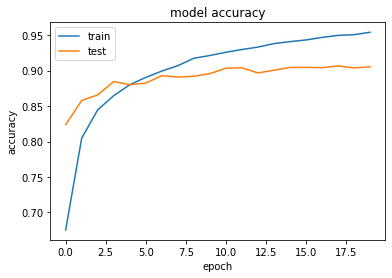

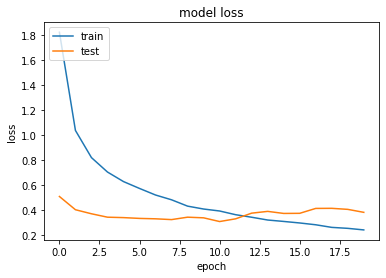

In [82]:
# Accuracy History Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss History Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### ***Evaluating model on validation data***

In [83]:
# Evaluating Model on the validation data using evaluate_generator method
score = model.evaluate_generator(validation_generator, validation_generator.n // validation_generator.batch_size)
print("Loss: ", score[0], "Accuracy: ", score[1])

Loss:  0.39188462495803833 Accuracy:  0.9063511490821838


### ***Making predictions on test data***

In [84]:
# Loading provided test images to test our model with them
X_test = np.load('/kaggle/working/test_rot.npy', allow_pickle=True)
X_test = X_test.astype('float32')

# Predict and save output to reco_nav.csv for submission on kaggle
res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="Id")

In [85]:
# Creating a link to download the predictions output on test images
os.chdir(r'/kaggle/working/')
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv

In [107]:
# Display some predictions on Test images
!head -40 reco_nav.csv

Id,Category
0,12
1,9
2,2
3,0
4,9
5,1
6,0
7,1
8,12
9,8
10,12
11,9
12,9
13,0
14,9
15,11
16,0
17,2
18,5
19,5
20,12
21,2
22,5
23,9
24,6
25,5
26,0
27,9
28,8
29,1
30,12
31,1
32,2
33,6
34,1
35,7
36,12
37,1
38,0


### ***Classification Report & Confusion Matrix***

In [87]:
# Reset Validation_generator to build a correct classification report
validation_generator.reset()

# Make predictions on validation data
predictions = model.predict_generator(validation_generator, steps=len(validation_generator))
# Extracting the max value from the predictions made on the validation data
val = np.argmax(predictions, axis=1)

# Make a Classification Report
report = classification_report(y_true=validation_generator.classes, y_pred=val, target_names=validation_generator.class_indices)
print(report)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


               precision    recall  f1-score   support

   coastguard       0.89      0.85      0.87       329
containership       0.99      0.99      0.99       674
     corvette       0.88      0.88      0.88       295
      cruiser       0.99      0.99      0.99       674
           cv       0.95      0.90      0.92       196
    destroyer       0.92      0.95      0.94       680
        ferry       0.96      0.93      0.95       342
    methanier       0.97      0.98      0.98       335
      sailing       0.89      0.98      0.93       165
    smallfish       0.70      0.48      0.57       317
    submarine       0.93      0.95      0.94       286
          tug       0.94      0.91      0.92       329
   vsmallfish       0.59      0.77      0.67       323

     accuracy                           0.91      4945
    macro avg       0.89      0.89      0.89      4945
 weighted avg       0.91      0.91      0.90      4945



<AxesSubplot:>

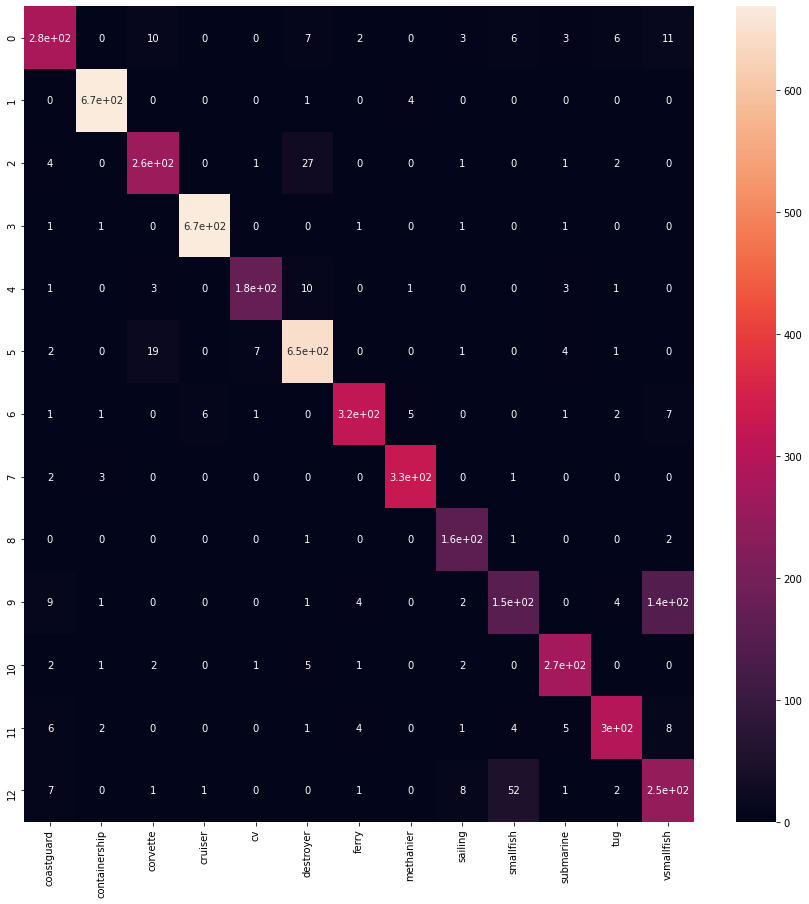

In [88]:
# Displaying a Confusion Matrix
con_matrix = confusion_matrix(validation_generator.classes, val)
df = pd.DataFrame(con_matrix, columns=validation_generator.class_indices)
plt.figure(figsize=(15,15))

# Using Seaborn to plot the Confusion Matrix
import seaborn as sn
sn.heatmap(df, annot=True)

### ***Testing on 20+ images to do a test on realife data very diffrent from provided training data***

0


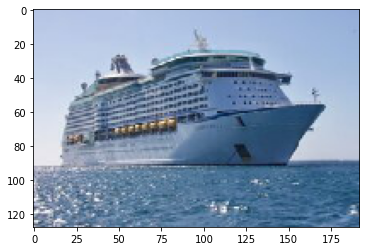

In [108]:
from keras_preprocessing.image import img_to_array, array_to_img, load_img
import matplotlib.pyplot as plt
test = '/kaggle/working/test'
categories = os.listdir(test)
XT = []
yt = []
for dirname, _, filenames in os.walk(test):
    dirn = dirname.split(os.path.sep)[-1]
    if (dirn != 'test'):
        cat = categories.index(str(dirn))
        for filename in filenames[:4]:
            img = load_img(str(os.path.join(dirname, filename)),
                           target_size=(128, 192 ))
            img_array = img_to_array(img) / 255
            XT.append(img_array)
            yt.append(cat)

print(yt[2])
plt.imshow(XT[2])
XT = np.array(XT)

In [98]:
XT = XT.astype('float32')
res = model.predict(XT).argmax(axis=1)
sum(yt == res) / len(res) * 100

7.6923076923076925

In [117]:
# Test directory where pers
TEST_DIR = "/kaggle/working/test"

testgen = ImageDataGenerator(rescale=1./255)

test_generator = testgen.flow_from_directory(
        TEST_DIR,
        target_size=(128, 192),
        batch_size=4,
        class_mode='categorical',
)

test_score = model.evaluate_generator(test_generator, len(test_generator))
print("Loss: ", test_score[0], "Accuracy: ", test_score[1])

Found 52 images belonging to 13 classes.
Loss:  3.0048718452453613 Accuracy:  0.07692307978868484


In [118]:
# Confirming that all classes have the same num of images
counter = Counter(test_generator.classes)                          
max_val = float(max(counter.values()))       
class_weight = {class_id : num_images for class_id, num_images in counter.items()}    
class_weight

{0: 4,
 1: 4,
 2: 4,
 3: 4,
 4: 4,
 5: 4,
 6: 4,
 7: 4,
 8: 4,
 9: 4,
 10: 4,
 11: 4,
 12: 4}

In [119]:
test_generator.reset()
testpredictions = model.predict_generator(test_generator, steps=len(test_generator))
testy = np.argmax(testpredictions, axis=1)

testreport = classification_report(y_true=test_generator.classes, y_pred=testy, target_names=test_generator.class_indices)
print(testreport)

               precision    recall  f1-score   support

   coastguard       0.00      0.00      0.00         4
containership       0.00      0.00      0.00         4
     corvette       0.00      0.00      0.00         4
      cruiser       0.00      0.00      0.00         4
           cv       0.00      0.00      0.00         4
    destroyer       0.00      0.00      0.00         4
        ferry       0.08      1.00      0.14         4
    methanier       0.00      0.00      0.00         4
      sailing       0.00      0.00      0.00         4
    smallfish       0.00      0.00      0.00         4
    submarine       0.00      0.00      0.00         4
          tug       0.00      0.00      0.00         4
   vsmallfish       0.00      0.00      0.00         4

     accuracy                           0.08        52
    macro avg       0.01      0.08      0.01        52
 weighted avg       0.01      0.08      0.01        52



/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245

<AxesSubplot:>

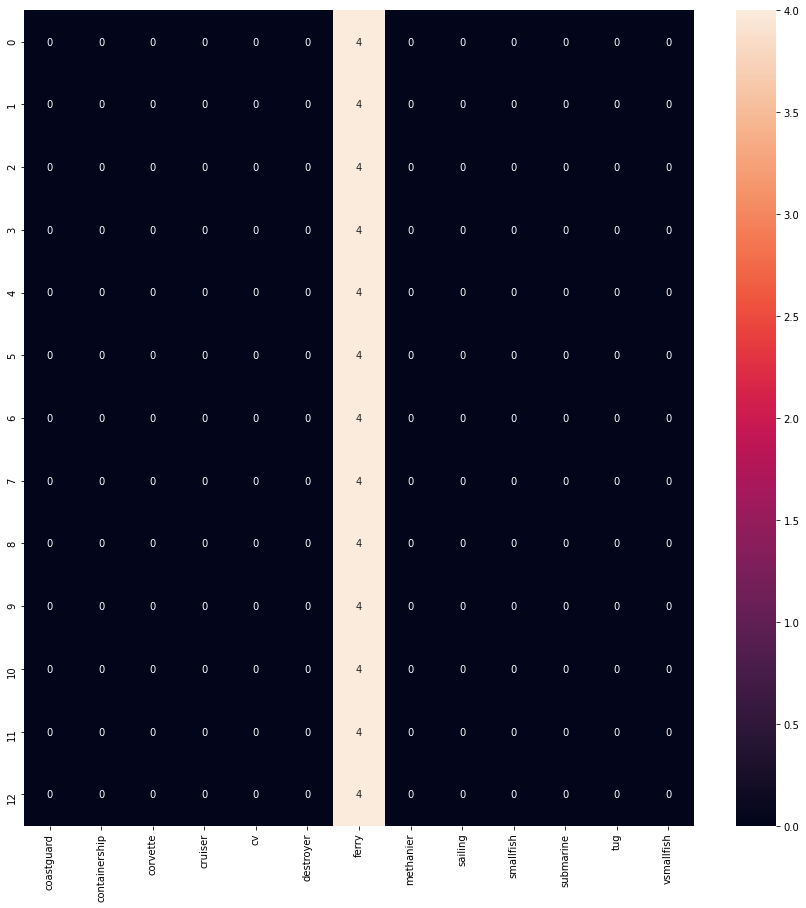

In [120]:
testmatrix = confusion_matrix(test_generator.classes, testy)
testdf = pd.DataFrame(testmatrix, columns=test_generator.class_indices)
plt.figure(figsize=(15,15))
import seaborn as sn
sn.heatmap(testdf, annot=True)

**By loading data manually we can see that the model exclusively detects the class 'ferry' whereas the same model works more than fine on the test dataset provided in the test_rot.npy file. With the provided test dataset, the model reaches about 88.331% (0.88331 cf. leaderboard of the kaggle competition ships 2021)**

**The model is performing abnormally on the test dataset that i've uploaded and only gets 7.3% of correct predictions. I wasn't able to find the culprit behind this but my guess is that the 52+ images i gathered from the internet are not behaving as they should.**
### I have some idea on why this is happening :
* This might come from the fact that all images have a format of 200x200
* The data struture of the test folder at /kaggle/working/test is similar to the stucture of train folder in ships.tgz, therefore this doesn't seem to be the problem here.
* Two types of tests/evaluation were conducted on the uploaded ships_test.tgz (one is by loading the test images with flow_from directory & ImageDataGenrator And the other one is  by using keras.preprocessing.load_image). Thus confirming that this problem is not linked to the methode use to load or evaluate the test images.
* I was lacking time for creating another test dataset and couldn't explore the posibility of a bad dataset by replacing the one i've tested here therefore my guess is that that's what is going wrong here.